## Exploring_lambda

This code solves the QLC problem in Fourier space. Parameters include:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In [68]:
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
import numpy as np
from copy import copy as cp
import matplotlib.pylab as plt
from scipy.integrate import solve_ivp
from numba import njit, float64, int32, types
from matplotlib import rcParams
from time import time
from scipy.fft import fftfreq, rfftfreq
from scipy.fft import rfft, irfft
# from scipy.fft import dct as rfft
# from scipy.fft import idct as irfft

import sys
sys.path.append('..')
import QLCstuff as QLC
import f90nml

In [69]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
markersize = 10

### Getting parameters for this run

In [70]:
inputfile = "GI parameters - Reference limit cycle (for testing).nml"

# For readability ...
print('Using parameter file '+inputfile+' ...')

print('\nFrom the GrowthInstability (GI) namelist:')
GI=f90nml.read(inputfile)['GI'] # Read the main parameter namelist

# Supersaturation at the corner of a facet
sigmaI_corner = GI['sigmaI_corner']
sigmaI_corner_units = GI['sigmaI_corner_units']
sigmaI_corner = AssignQuantity(sigmaI_corner,sigmaI_corner_units)
print('sigmaI_corner =', sigmaI_corner)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = GI['sigma0']
sigma0_units = GI['sigma0_units']
sigma0 = AssignQuantity(sigma0,sigma0_units)
print('sigma0 =',sigma0)

# Reduction of supersaturation at the facet cental
c_r = GI['c_r']
c_r_units = GI['c_r_units']
c_r = AssignQuantity(c_r,c_r_units)
print('c_r =',c_r)

# Properties of the QLL
Nbar = GI['Nbar']; print('Nbar', Nbar)
Nstar = GI['Nstar']; print('Nstar', Nstar)

# Thickness of monolayers
h_pr = GI['h_pr']
h_pr_units = GI['h_pr_units']
h_pr = AssignQuantity(h_pr,h_pr_units) 
print('h_pr =', h_pr)

# Diffusion coeficient
D = GI['D']
D_units = GI['D_units']
D = AssignQuantity(D,D_units)
print('D =', D)

# Deposition velocity
nu_kin = GI['nu_kin']
nu_kin_units = GI['nu_kin_units']
nu_kin = AssignQuantity(nu_kin,nu_kin_units)
print('nu_kin =', nu_kin)

# Size of the facet
L = GI['L']
L_units = GI['L_units']
L = AssignQuantity(L,L_units)
print('L =', L)

# Crystal size -- needs to be an even number
nx_crystal = GI['nx_crystal']
print('nx (crystal) =', nx_crystal)

# Time constant for freezing/thawing
tau_eq = GI['tau_eq']
tau_eq_units = GI['tau_eq_units']
tau_eq = AssignQuantity(tau_eq,tau_eq_units)
print('tau_eq =',tau_eq)

# Integration algorithm (possibilities: RK45, BDF, RK23, DOP853, LSODA, and Radau)
odemethod = GI['odemethod']
print('odemethod =',odemethod)

Using parameter file GI parameters - Reference limit cycle (for testing).nml ...

From the GrowthInstability (GI) namelist:
sigmaI_corner = 0.21 dimensionless
sigma0 = 0.2 dimensionless
c_r = 0.005 dimensionless
Nbar 1
Nstar 0.1
h_pr = 0.389 nanometer
D = 0.000365 micrometer ** 2 / microsecond
nu_kin = 70 micrometer / second
L = 30 micrometer
nx (crystal) = 320
tau_eq = 5 microsecond
odemethod = RK45


In [71]:
# Conversions (in case inputs are in other units)
sigma0.ito('dimensionless')
h_pr.ito('micrometer')
D.ito('micrometer^2/microsecond')
nu_kin.ito('micrometer/second')
L.ito('micrometer')
sigmaI_corner.ito('dimensionless')
c_r.ito('dimensionless')
tau_eq.ito('microsecond')

### Varibles that depend on the above

In [72]:
x_QLC = np.linspace(-L,L,nx_crystal)
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Runtime parameters from the namelist 

In [73]:
RT=f90nml.read(inputfile)['RT'] # Read the main parameter namelist

# How long
runtime = RT['runtime']
runtime_units = RT['runtime_units']
runtime = AssignQuantity(runtime,runtime_units)
print('runtime =', runtime)
runtime.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = RT['ntimes']

# Flag if we want more output
verbose = RT['verbose']

# Specify the time interval and initial conditions
tkeep_1Darr = np.linspace(0,runtime,ntimes)
Ntot_init_1D = np.ones(nx_crystal)
NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

runtime = 300 millisecond
This is a run from time 0.0 millisecond to 300.0 millisecond
dt = 6122.448979591837 microsecond


### Run the scenario (in FT space)

In [74]:
DoverL2pi2 = D/L**2*np.pi**2
Ntotkeep_1D_FT, NQLLkeep_1D_FT = QLC.run_f1d_FT(\
           NQLL_init_1D,Ntot_init_1D,tkeep_1Darr,\
           Nbar, Nstar, sigma0, nu_kin_mlyperus, DoverL2pi2, tau_eq, sigmaI_QLC,\
           AssignQuantity,\
           verbose=0, odemethod='RK45')
Nicekeep_1D_FT = Ntotkeep_1D_FT-NQLLkeep_1D_FT

10 % elapsed time is 0.075 minutes
20 % elapsed time is 0.140 minutes
30 % elapsed time is 0.204 minutes
40 % elapsed time is 0.269 minutes
50 % elapsed time is 0.334 minutes
60 % elapsed time is 0.400 minutes
70 % elapsed time is 0.465 minutes
80 % elapsed time is 0.530 minutes
90 % elapsed time is 0.595 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']


<IPython.core.display.Javascript object>


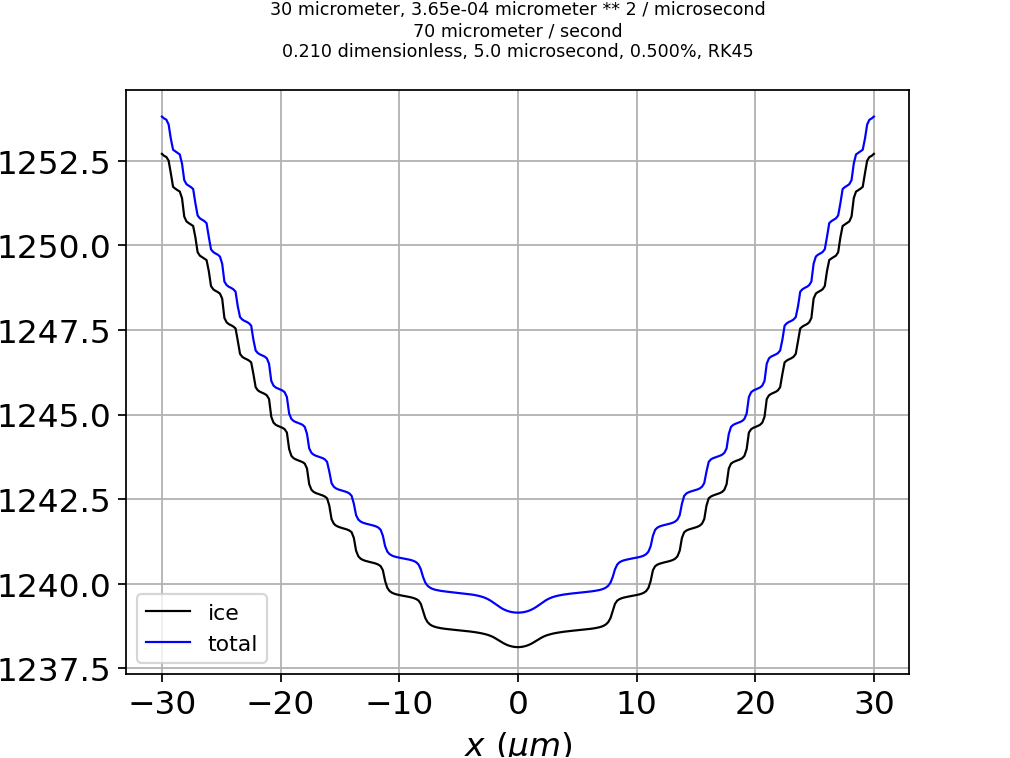

<IPython.core.display.Javascript object>


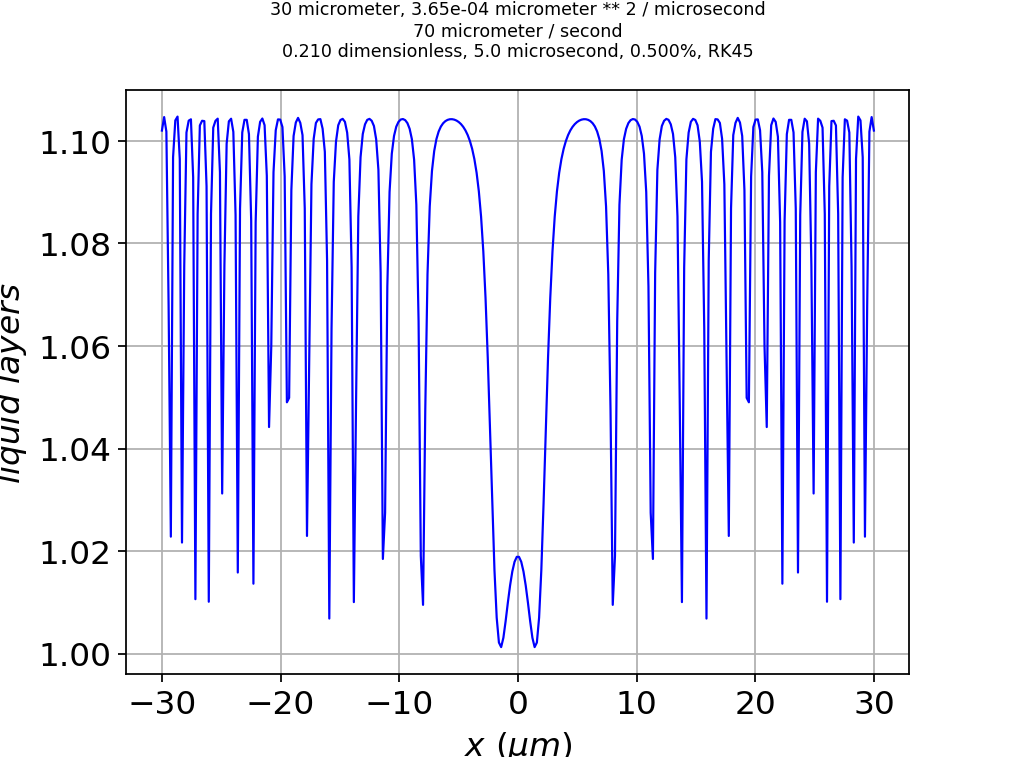

<IPython.core.display.Javascript object>


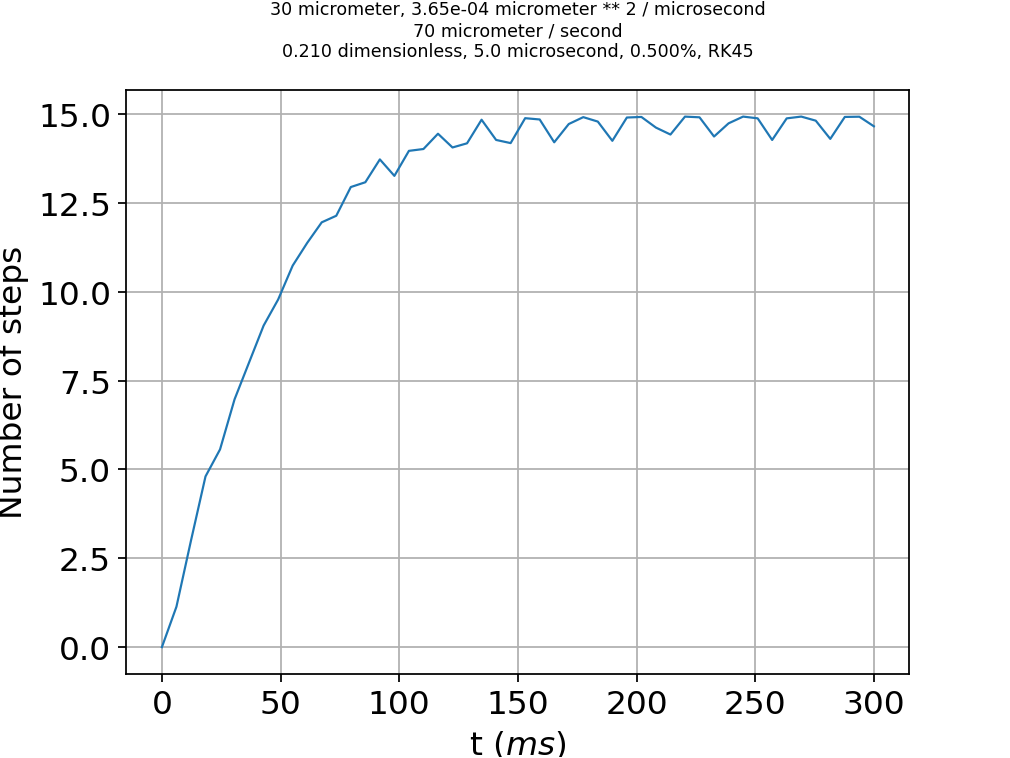

<IPython.core.display.Javascript object>


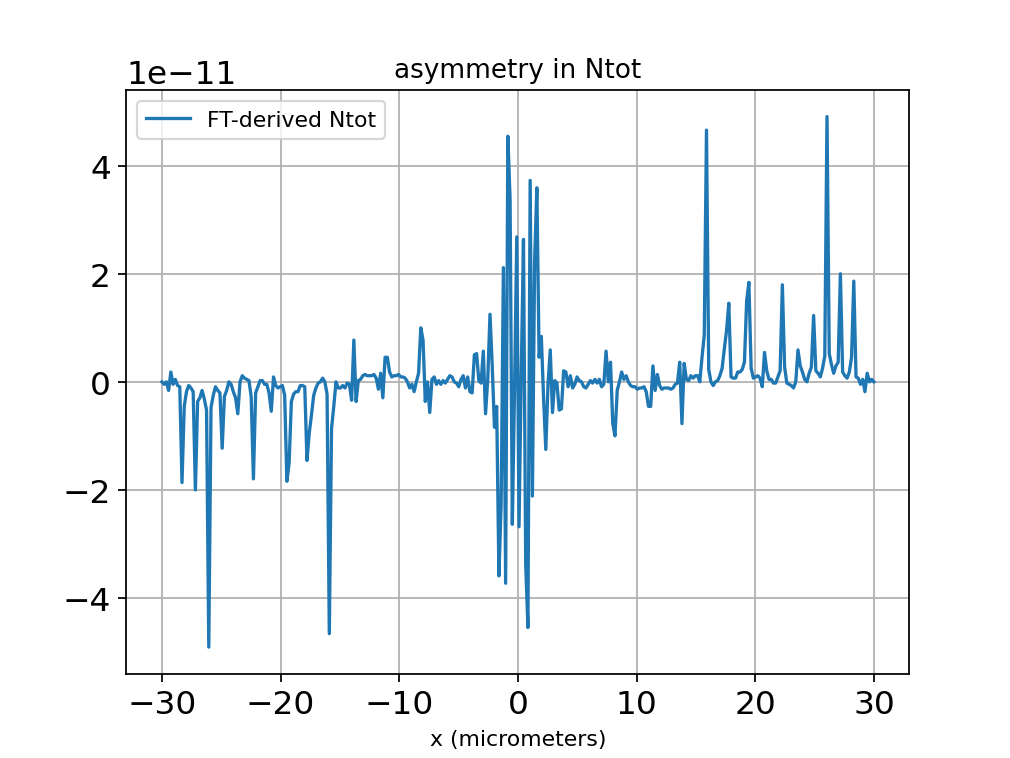

<IPython.core.display.Javascript object>


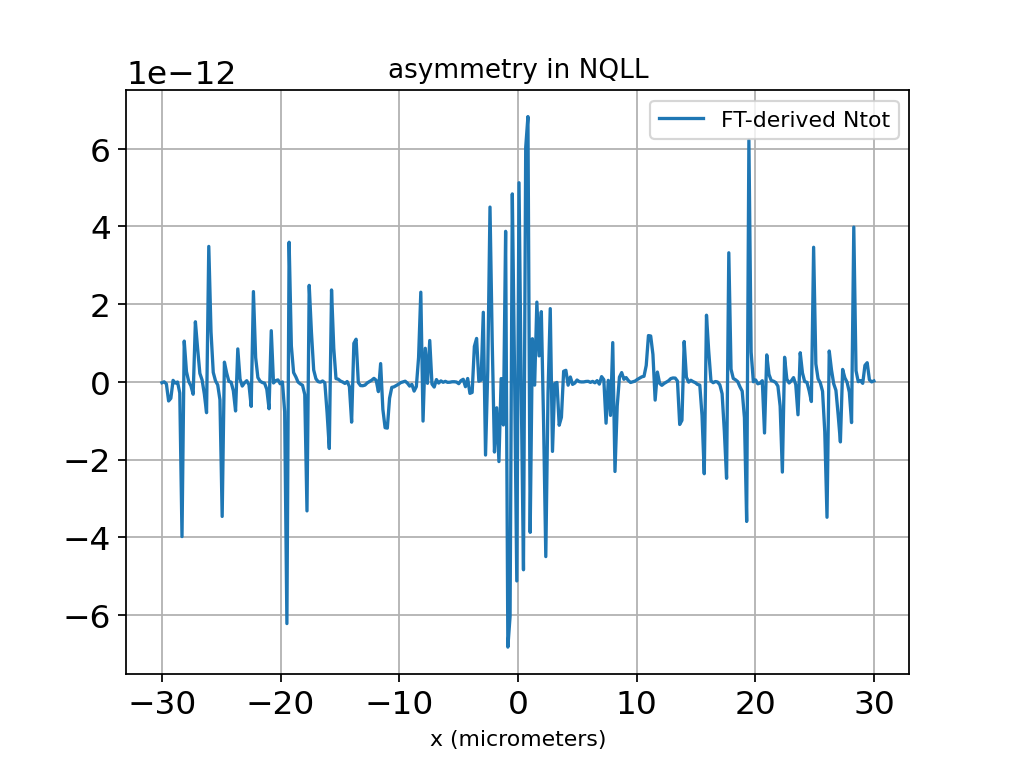

<IPython.core.display.Javascript object>


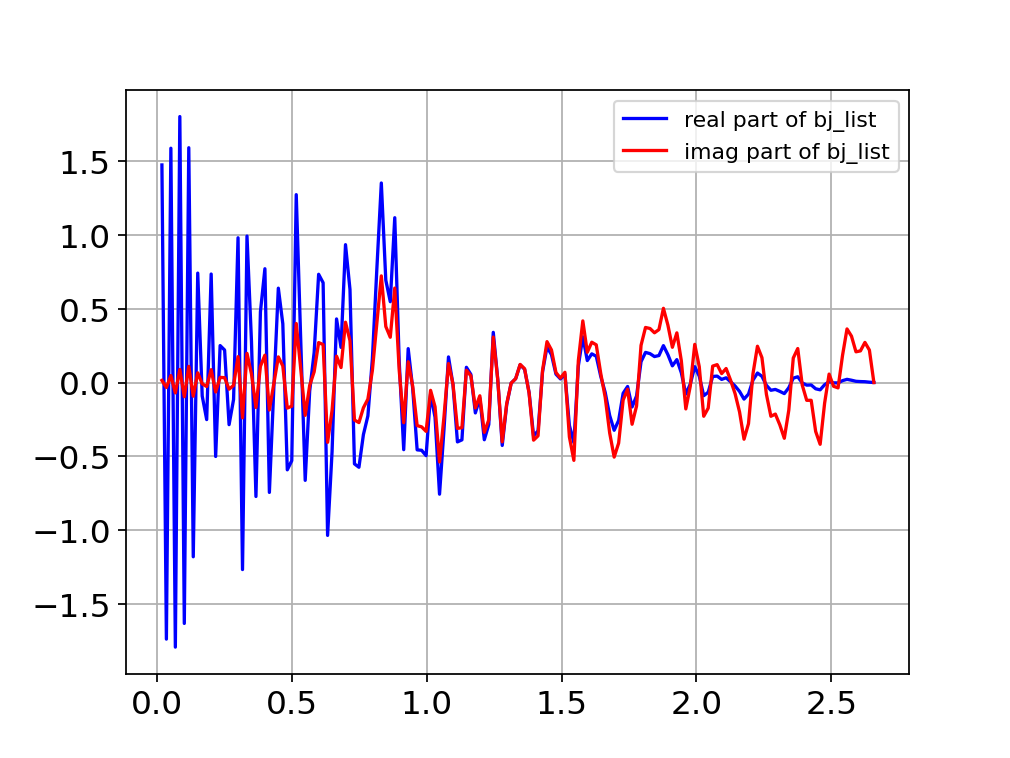

<IPython.core.display.Javascript object>


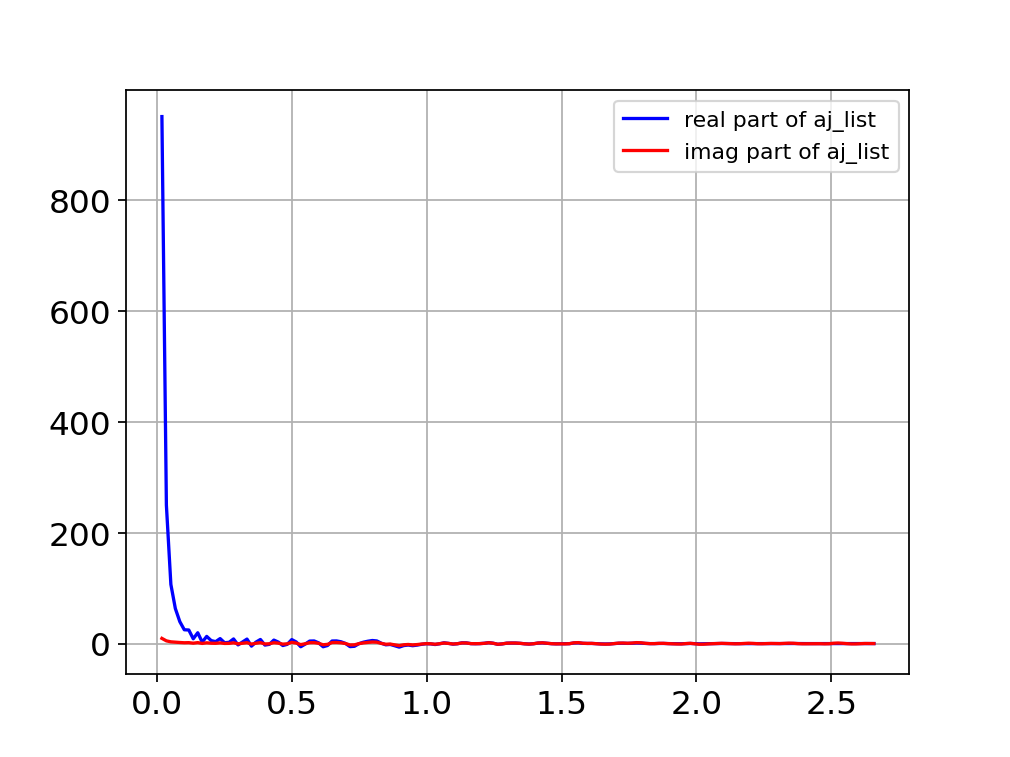

In [75]:
# Reporting

# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r.to('percent').magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D_FT,Ntotkeep_1D_FT,Nicekeep_1D_FT,h_pr, \
        graphics=True,title_params=title_params)

Ntot_difference_FT = Ntotkeep_1D_FT[-1]-np.flip(Ntotkeep_1D_FT[-1])
plt.figure()
plt.plot(x_QLC.magnitude,Ntot_difference_FT,label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()
plt.title('asymmetry in Ntot')

NQLL_difference_FT = NQLLkeep_1D_FT[-1]-np.flip(NQLLkeep_1D_FT[-1])
plt.figure()
plt.plot(x_QLC.magnitude,NQLL_difference_FT,label='FT-derived Ntot')
plt.xlabel('x (micrometers)')
plt.grid(True)
plt.legend()
plt.title('asymmetry in NQLL')

kvalues = rfftfreq(nx_crystal,deltax)
bj_list = rfft(NQLLkeep_1D_FT[-1])

plt.figure()
plt.plot(kvalues[1:].magnitude,np.real(bj_list)[1:],'b',label='real part of bj_list')
plt.plot(kvalues[1:].magnitude,np.imag(bj_list)[1:],'r',label='imag part of bj_list')
plt.grid(True)
plt.legend()

aj_list = rfft(Ntotkeep_1D_FT[-1])
plt.figure()
plt.plot(kvalues[1:].magnitude,np.real(aj_list)[1:],'b',label='real part of aj_list')
plt.plot(kvalues[1:].magnitude,np.imag(aj_list)[1:],'r',label='imag part of aj_list')
plt.grid(True)
plt.legend()

In [79]:
# The wavelength
ntimes = len(tkeep_1Darr)
ntimes_to_limit_cycle = int(ntimes*.75)
imid = int(nx_crystal/2)
Ntotkeep_for_lambda = Ntotkeep_1D_FT[ntimes_to_limit_cycle:ntimes][0]
lambda_values = L/(Ntotkeep_for_lambda[0]-Ntotkeep_for_lambda[imid])
print(lambda_values)
# print('sigma_corner and lambda:')
# print(sigmaI_corner.magnitude,lambda_value.magnitude)

2.011939869647206 micrometer


In [80]:
Ntotkeep_for_lambda

array([950.75226641, 950.68808888, 950.64401818, 949.91611706,
       949.83917595, 949.76776703, 949.73362572, 949.65984535,
       949.47450455, 948.86743902, 948.80558898, 948.75497887,
       948.71558866, 948.63494332, 948.19198056, 947.85207739,
       947.79082049, 947.74956194, 947.70743434, 947.62638546,
       947.12687304, 946.85436736, 946.79125511, 946.7522675 ,
       946.71417621, 946.64670113, 946.27633105, 945.88174174,
       945.8074872 , 945.76431024, 945.73242188, 945.68242584,
       945.57137627, 945.00692211, 944.84910235, 944.79044193,
       944.75642177, 944.7244007 , 944.67409168, 944.53986308,
       944.00124641, 943.8510056 , 943.79429266, 943.761464  ,
       943.73178766, 943.6925566 , 943.61638968, 943.19746156,
       942.8973615 , 942.82002896, 942.78056795, 942.75205178,
       942.72415389, 942.6838252 , 942.60073347, 942.1823439 ,
       941.90397398, 941.8264407 , 941.78695282, 941.76003906,
       941.73454528, 941.70579515, 941.65391079, 941.50

In [78]:
len(tkeep_1Darr)

50